In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import requests
from urllib.request import Request, urlopen
pd.options.display.max_rows = 1500
pd.options.display.max_columns = 1500
%matplotlib inline

In [2]:
cnn = pd.read_csv('../data/cnn_pubmed.csv', sep = ",")
impact_factor = pd.read_csv('../data/JournalHomeGrid.csv', header = 1)
impact_factor.columns = ['Rank', 'journal_title', 'total_cites', 'impact_factor',
       'eigenfactor_score']

In [3]:
impact_factor['journal_title'] = impact_factor.journal_title.str.lower()
impact_factor[impact_factor.journal_title.str.contains('sensors', na= False)]
cnn.journal_title = cnn.journal_title.str.lower()
cnn['journal_title'] = cnn['journal_title'].str.replace('(\s\:.*$)',"")
cnn.journal_title = cnn.journal_title.str.replace("(\(.*\))", '').str.strip()

In [4]:
cnn['Published_year'] = pd.to_numeric(cnn['Published_year'])
cnn.publication_type = cnn.publication_type.str.replace('Journal Article,', "", regex = True)
cnn.publication_type = cnn.publication_type.str.replace(',Journal Article', "", regex = True)

In [5]:
# merge dataframes
cnn = cnn.merge(impact_factor, left_on = 'journal_title', right_on = 'journal_title', how = 'left')

In [6]:
cnn.isnull().sum()

PMID                      0
Title                     0
ISOAbbreviation           0
journal_title             0
Abstract                 29
Journalinfo_country       0
Published_year            0
Keyword_list           1935
publication_type          0
medline_citation          0
pubmed_year               0
Affiliation             956
Rank                    747
total_cites             747
impact_factor           747
eigenfactor_score       747
dtype: int64

In [7]:
missing =cnn.columns[cnn.isna().any()]
display(cnn[cnn["PMID"].isnull()][missing])
missing

,Abstract,Keyword_list,Affiliation,Rank,total_cites,impact_factor,eigenfactor_score


Index(['Abstract', 'Keyword_list', 'Affiliation', 'Rank', 'total_cites',
       'impact_factor', 'eigenfactor_score'],
      dtype='object')

## Analysis manuscript without review articles

In [8]:
minus_reviews =cnn[~cnn.publication_type.str.contains("Review|Comment|Editorial|Letter|Published Erratum")==True]
minus_reviews.publication_type.value_counts()

Journal Article                                            4096
Comparative Study                                            30
Validation Studies                                           29
Evaluation Studies                                           28
Multicenter Study                                             8
Comparative Study,Evaluation Studies                          7
English Abstract                                              5
Comparative Study,Validation Studies                          4
Clinical Trial                                                4
Comparative Study,Evaluation Studies,Validation Studies       3
Video-Audio Media                                             3
Observational Study                                           2
Randomized Controlled Trial                                   2
Dataset                                                       2
Retraction of Publication                                     2
Multicenter Study,Validation Studies    

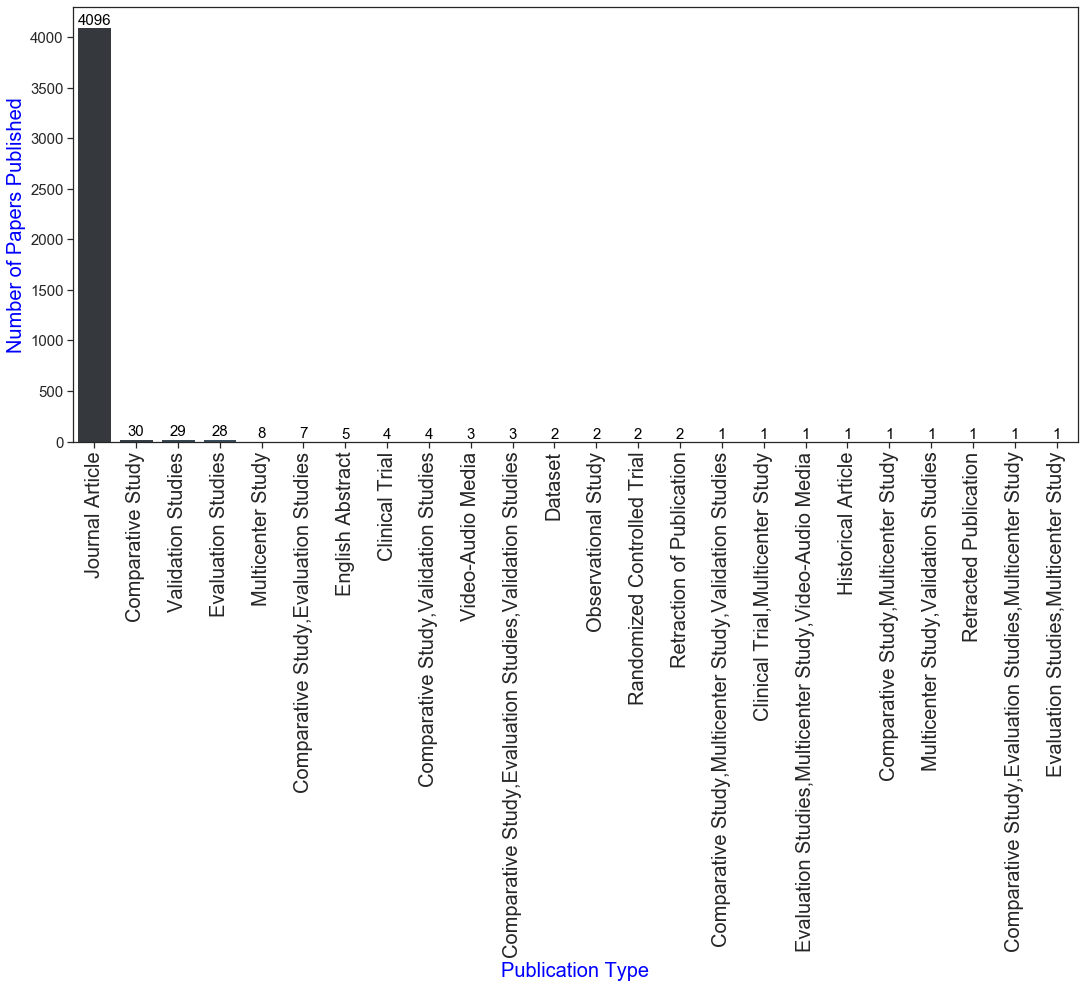

In [9]:
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")
publication_type = minus_reviews.groupby('publication_type')['PMID'].count().reset_index()\
                        .sort_values('PMID', ascending =False).reset_index(drop= True).head(30)
ax =sns.barplot(x = 'publication_type', y = 'PMID', data = publication_type, palette ="Blues_d")
plt.xlabel('Publication Type',fontsize = 20, color = 'blue')
plt.ylabel('Number of Papers Published',fontsize = 20, color = 'blue')
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 15)
for index, row in publication_type.iterrows():
    ax.text(row.name,row.PMID, round(row.PMID),color='black', ha="center",fontsize = 15, va='bottom')#, clip_on= True);


In [10]:
num_published_year= minus_reviews.groupby('Published_year')['PMID'].count().reset_index()\
                        .sort_values('Published_year', ascending =False)\

num_published_year

,Published_year,PMID
21,2020,7
20,2019,2184
19,2018,1307
18,2017,514
17,2016,139
16,2015,47
15,2014,8
14,2013,6
13,2012,3
12,2011,1


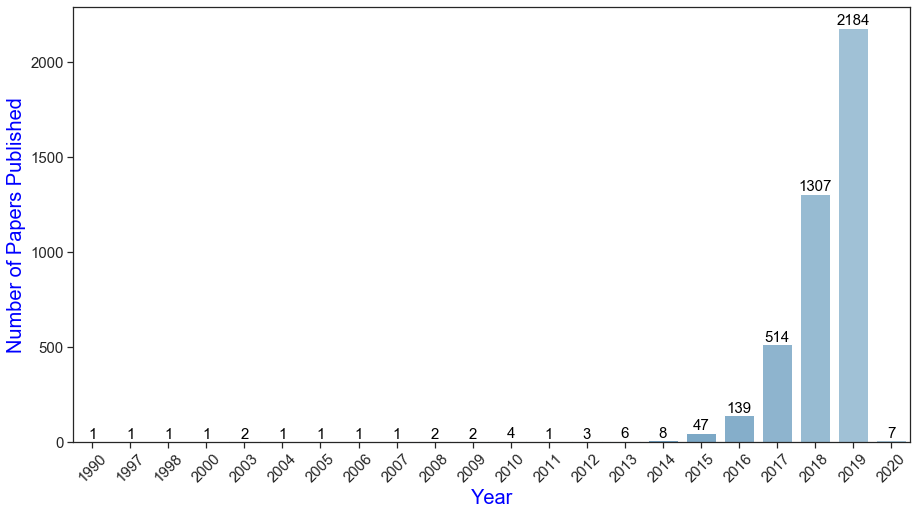

In [11]:
sns.set(rc={'figure.figsize':(15,8)}, style ='white' )
sns.set_style("ticks")
num_published_year= minus_reviews.groupby('Published_year')['PMID'].count().reset_index()\
                        .sort_values('Published_year', ascending =False)
g =sns.barplot(x = 'Published_year', y = 'PMID', data = num_published_year, palette ="Blues_d")
plt.xlabel('Year',fontsize = 20, color = 'blue')
plt.ylabel('Number of Papers Published',fontsize = 20, color = 'blue')
plt.xticks(fontsize = 15, rotation = 45)
plt.yticks(fontsize = 15)
for index, row in num_published_year.iterrows():
    g.text(row.name,row.PMID, round(row.PMID), color='black', ha="center", fontsize = 15, va='bottom');

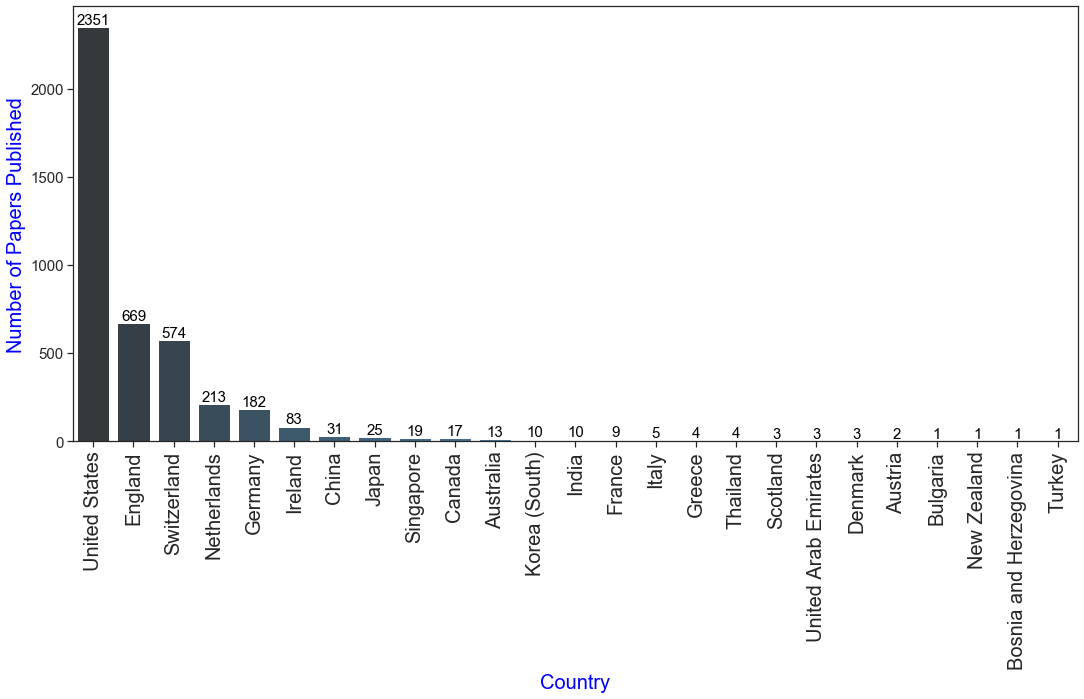

In [12]:
sns.set(rc={'figure.figsize':(18,8)}, style ='white')
sns.set_style("ticks")
num_published_country= minus_reviews.groupby('Journalinfo_country')['PMID'].count().reset_index()\
                        .sort_values('PMID', ascending =False).reset_index(drop= True)\

g =sns.barplot(x = 'Journalinfo_country', y = 'PMID', data = num_published_country, palette ="Blues_d")
plt.xlabel('Country',fontsize = 20, color = 'blue')
plt.ylabel('Number of Papers Published',fontsize = 20, color = 'blue')
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 15)
for index, row in num_published_country.iterrows():
    g.text(row.name,row.PMID, round(row.PMID), color='black', ha="center", fontsize = 15, va='bottom');

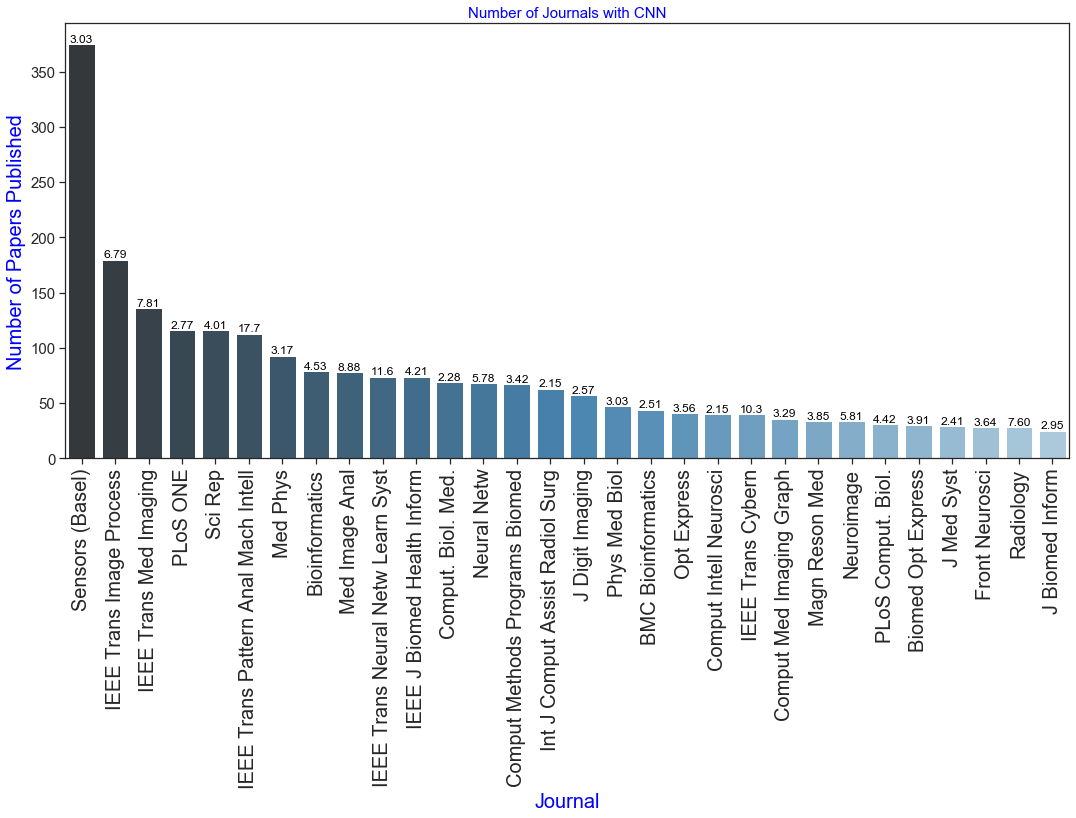

In [13]:
sns.set(rc={'figure.figsize':(18,8)}, style ='white')
sns.set_style("ticks")

total_published=  minus_reviews.groupby(['ISOAbbreviation', 'impact_factor'])[['PMID']].count()\
    .reset_index().sort_values('PMID', ascending = False).reset_index(drop= True).head(30)
g =sns.barplot(x = 'ISOAbbreviation', y = 'PMID', data = total_published, palette ="Blues_d")
plt.xlabel('Journal',fontsize = 20, color = 'blue')
plt.ylabel('Number of Papers Published',fontsize = 20, color = 'blue')
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 15)
plt.title('Number of Journals with CNN', fontsize = 15, color = 'blue')

for index, row in total_published.iterrows():
    g.text(row.name,row.PMID, str(row.impact_factor[0:4]),color='black', ha="center", fontsize = 12, va='bottom');

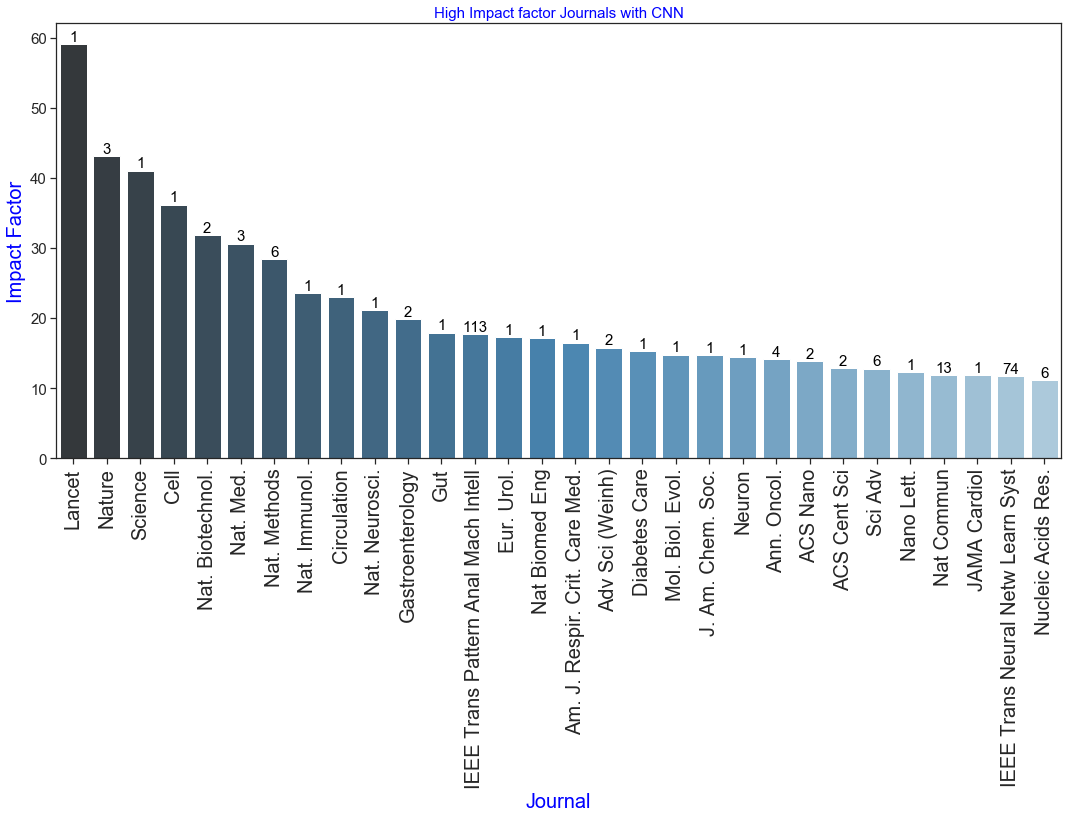

In [14]:
sns.set(rc={'figure.figsize':(18,8)}, style ='white')
sns.set_style("ticks")
highimpact_journal= minus_reviews.groupby(['ISOAbbreviation','impact_factor'])['PMID'].count()\
            .sort_values(ascending = False).reset_index()              
highimpact_journal['impact_factor']=highimpact_journal.impact_factor.str.replace('Not Available', "0.0")
highimpact_journal['impact_factor']=highimpact_journal.impact_factor.astype('float')
highimpact_journal=highimpact_journal.sort_values('impact_factor', ascending = False).reset_index()
highimpact_journal=highimpact_journal.drop('index', axis=1).head(30)
g =sns.barplot(x = 'ISOAbbreviation', y = 'impact_factor', data = highimpact_journal, palette ="Blues_d")
plt.xlabel('Journal',fontsize = 20, color = 'blue')
plt.ylabel('Impact Factor',fontsize = 20, color = 'blue')
plt.xticks(fontsize = 20, rotation = 90)
plt.yticks(fontsize = 15)
plt.title('High Impact factor Journals with CNN', fontsize = 15, color = 'blue')

for index, row in highimpact_journal.iterrows():
    g.text(row.name,row.impact_factor, round(row.PMID,1),color='black', ha="center", fontsize = 15, va='bottom');